# Рекуррентные нейросети

![RNN](https://habrastorage.org/web/a9b/1e6/40f/a9b1e640f6264b0a902e851eb5f29e08.png)
![RNN full](https://habrastorage.org/web/5c8/0fa/c22/5c80fac224d449209d888d18ea1111a8.png)

# Попробуем запилить простую RNN для предсказания временных рядов

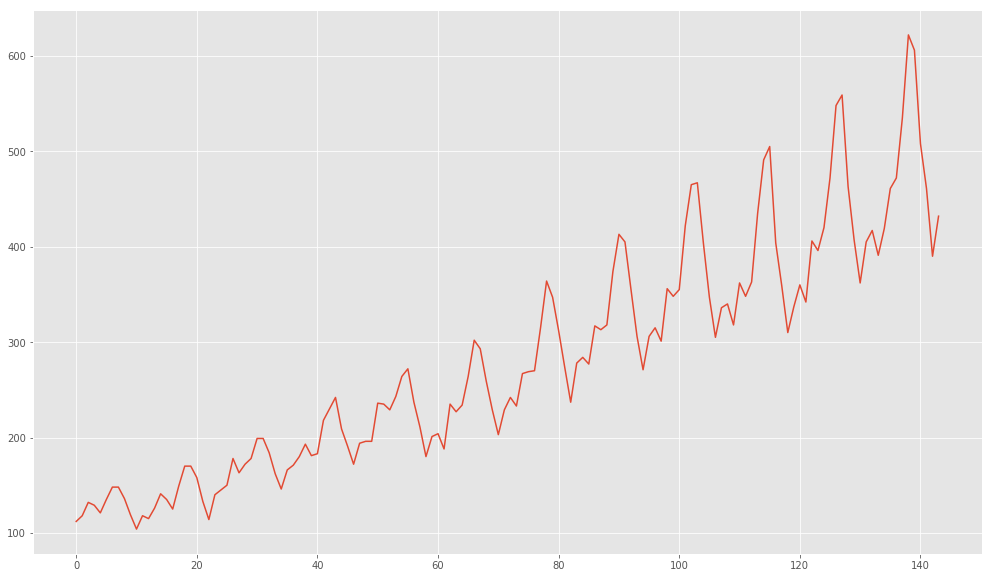

In [24]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10

dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [25]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет хавать только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

(96, 48)


In [26]:
# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [27]:
# А вот и вся наша нейросетка :)
model = Sequential()
model.add(SimpleRNN(4, batch_input_shape=(1, look_back, 1))) # 4 - размерность выхода, batch_input_shape = [batch_size, time steps, features]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0754
Epoch 2/100
0s - loss: 0.0294
Epoch 3/100
0s - loss: 0.0232
Epoch 4/100
0s - loss: 0.0193
Epoch 5/100
0s - loss: 0.0159
Epoch 6/100
0s - loss: 0.0129
Epoch 7/100
0s - loss: 0.0100
Epoch 8/100
0s - loss: 0.0076
Epoch 9/100
0s - loss: 0.0058
Epoch 10/100
0s - loss: 0.0045
Epoch 11/100
0s - loss: 0.0035
Epoch 12/100
0s - loss: 0.0029
Epoch 13/100
0s - loss: 0.0025
Epoch 14/100
0s - loss: 0.0023
Epoch 15/100
0s - loss: 0.0022
Epoch 16/100
0s - loss: 0.0021
Epoch 17/100
0s - loss: 0.0020
Epoch 18/100
0s - loss: 0.0020
Epoch 19/100
0s - loss: 0.0020
Epoch 20/100
0s - loss: 0.0020
Epoch 21/100
0s - loss: 0.0020
Epoch 22/100
0s - loss: 0.0020
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0020
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0019
Epoch 29/100
0s - loss: 0.0019
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [8]:
# получим предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.43 RMSE
Test Score: 61.10 RMSE


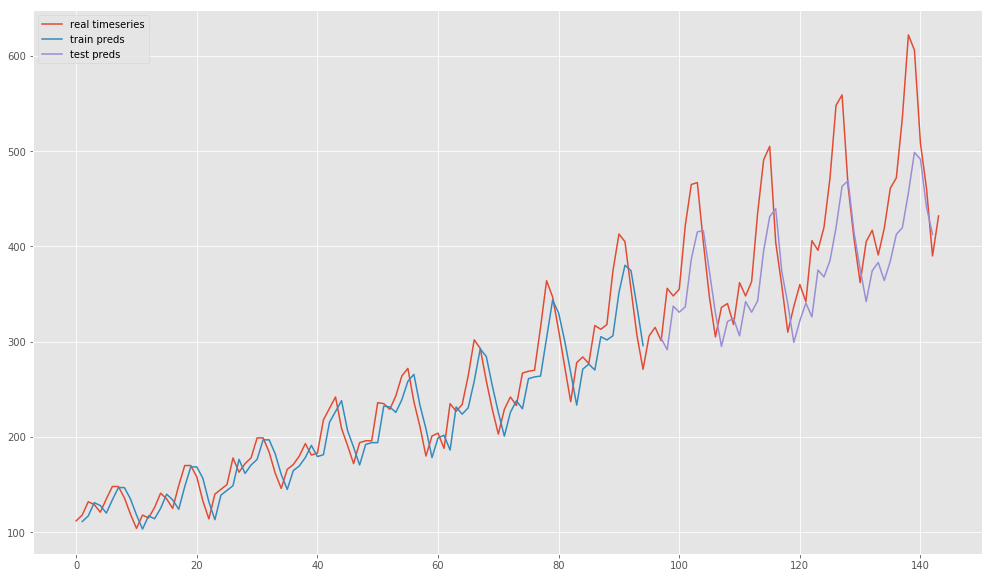

In [11]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='real timeseries')
plt.plot(trainPredictPlot, label='train preds')
plt.plot(testPredictPlot, label='test preds')
plt.legend()
plt.show()

# Сброс состояний перед каждым обучением

## Упражнение 1

In [28]:
# TODO: проделываем те же махинации до стадии с обучением

In [29]:
# Обучаем со сбросом состояний
for epoch in range(NB_EPOCHES):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=0)
    model.reset_states()

In [31]:
# TODO: посмотрите на качество предсказаний

## LSTM
![lstm](https://habrastorage.org/web/67b/04f/73b/67b04f73b4c34ba38edfa207e09de07c.png)

## Упражнение 2

In [30]:
from keras.layers import LSTM

# TODO проделайте все те же телодвижения с LSTM. Проверьте, есть ли прирост качества, и объясните полученные результаты

# Полезные ссылки
* Огненная [статья](https://habrahabr.ru/company/wunderfund/blog/331310/) про RNN и LSTM на Хабре
* Годная [статья](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) с подробным разбором примера на Keras